In [1]:
import sys
import os

PACKAGE_PARENT = '../../'
sys.path.append(PACKAGE_PARENT)

from alphaslime.evaluate.eval_agents import EvaluateGameSA
from alphaslime.agents.other.dqnAgent import DQNAgent
from alphaslime.approx.dqn import DQN
from alphaslime.envgame.slenv import SLenv
from alphaslime.agents.baseline import BaselineAgent
from alphaslime.epsilon.exp_epsilon import ExponentialDecay
from alphaslime.epsilon.linear_epsilon import LinearDecay
from alphaslime.approx.dqn import DQNv3
from alphaslime.approx.dqn import DQNv2

from alphaslime.trainer.trainerSA import TrainerSA

from pandas import read_csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gym
import csv

import time
import torch

In [2]:
logdir = './hyper/'
if not os.path.exists(logdir):
  os.makedirs(logdir)

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env_id = "SlimeVolley-v0"
env = gym.make(env_id)

# actions for slimeball
action_table = [[0, 0, 0], # NOOP
                [1, 0, 0], # LEFT (forward)
                [1, 0, 1], # UPLEFT (forward jump)
                [0, 0, 1], # UP (jump)
                [0, 1, 1], # UPRIGHT (backward jump)
                [0, 1, 0]] # RIGHT (backward)

config = {}
config['env'] = None
config['action_table'] =  action_table

# set opponent agent
opponent = BaselineAgent(config)

# create multi agent wrapper
env = SLenv(env=env, opponent=opponent)

n_actions = env.action_space.n
len_obs_space = env.observation_space.shape[0]

CONSTANTS = {
  'PATH': logdir,
  'action_table': action_table,
  'env': env
}
trainer = TrainerSA(CONSTANTS)


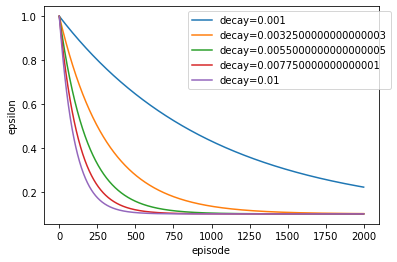

In [3]:
def eps(min_ep, max_ep, decay, episodes):
    return min_ep + (max_ep-min_ep)*np.exp(-decay*episodes)


episodes = np.arange(2000)
min_eps = 0.1
max_eps = 1
# decays = np.arange(0.001, 0.02,0.0002)
decays = np.linspace(0.001, 0.01,num=5)

for decay in decays:
    y = eps(min_eps, max_eps, decay, episodes)
    plt.plot(episodes, y, label='decay={}'.format(decay))
    plt.legend(bbox_to_anchor=(1.05, 1)) 

plt.xlabel('episode')
plt.ylabel('epsilon')
plt.show()

In [4]:
# Hyperparameters
#**********************************
gamma = 0.99
epsilon = 1
learning_rate = 0.001
EPISODES = 10000
# MINI_BATCH_SIZE = 64
MINI_BATCH_SIZE = 128
MEMORY_SIZE = 100000
TARGET_UPDATE = 10
hidden_layer_size = 128
threshold = -3

# epsilon decay: exponetial
min_epsilon = 0.05 
max_epsilon = 1
# decay_rate = 0.00325
decay_rate = 0.1
# epsilon decay: linear
# min_epsilon = 0.01
max_episode = 4000
#**********************************

layer_sizes = [len_obs_space, hidden_layer_size, n_actions]
is_progress = True

# epsilon decay model
eps_decay_exp = ExponentialDecay(min_epsilon, max_epsilon, decay_rate)
eps_decay_linear = LinearDecay(min_epsilon, max_episode)
decay_model = eps_decay_linear

In [5]:
hyperparams = {}
hyperparams['gamma'] = gamma
hyperparams['epsilon'] = epsilon
hyperparams['learning_rate'] = learning_rate
hyperparams['EPISODES'] = EPISODES
hyperparams['MINI_BATCH_SIZE'] = MINI_BATCH_SIZE
hyperparams['MEMORY_SIZE'] = MEMORY_SIZE
hyperparams['TARGET_UPDATE'] = TARGET_UPDATE
# hyperparams['hidden_layer_size'] = hidden_layer_size
hyperparams['epsilon_decay'] = decay_model
hyperparams['threshold'] = threshold
hyperparams['is_threshold_stop'] = False
hyperparams['is_progress'] = is_progress
hyperparams['layer_sizes'] = layer_sizes 
hyperparams['q_type'] = DQNv2 
hyperparams['agent_type'] = DQNAgent 

# Tuning

Lets tune the gamma and learning rates

In [6]:
gammas = np.arange(0.97,0.99,0.01)
print(len(gammas))
print(gammas)
# learning_rates = np.arange(0.0001, 0.001, 0.0001)

3
[0.97 0.98 0.99]


In [7]:
# for gamma in gammas:
#     print('-'*5)
#     print('gamma = {}'.format(gamma))
#     hyperparams['gamma'] = gamma
#     trainer.train(hyperparams)
#     # for learning_rate in learning_rates:
#     #     hyperparams['learning_rate'] = learning_rate
# print('-'*5)

In [8]:
# train agent
filenames = trainer.train(hyperparams)

100%|██████████| 10000/10000 [3:30:13<00:00,  1.26s/it]


In [9]:
import pickle
print(filenames)
model_path = filenames[0]
training_data_path = filenames[1]
hyperparams_data_path = filenames[2]
agent_cfg_data_path = filenames[3]
training_constants_path = filenames[4]

with open(training_data_path,'rb') as f:
    training_data = pickle.load(f)

with open(hyperparams_data_path,'rb') as f:
    hyperparams_data = pickle.load(f)

with open(agent_cfg_data_path,'rb') as f:
    agent_cfg = pickle.load(f)

with open(training_constants_path,'rb') as f:
    training_constants = pickle.load(f)



['./hyper/gamma_0.9900000095367432_lr_rate_0.001_reward_-4.82_model.pt', './hyper/gamma_0.9900000095367432_lr_rate_0.001_reward_-4.82_data.pkl', './hyper/gamma_0.9900000095367432_lr_rate_0.001_reward_-4.82_hyper.pkl', './hyper/gamma_0.9900000095367432_lr_rate_0.001_reward_-4.82_agent_cfg.pkl', './hyper/gamma_0.9900000095367432_lr_rate_0.001_reward_-4.82_CONSTANTS.pkl']


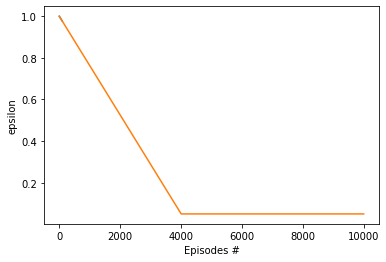

In [10]:
eps_list = training_data['epsilon']
plt.plot(eps_list[:100])
plt.plot(eps_list)
plt.ylabel('epsilon')
plt.xlabel('Episodes #')
plt.show()

dict_keys(['avg_rewards', 'rewards', 'epsilon', 'losses'])


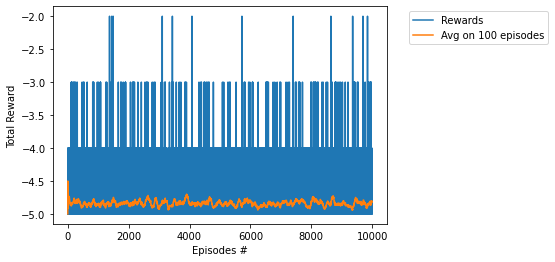

In [11]:
# plot data
rewards = training_data['rewards']
avg_rewards = training_data['avg_rewards']

print(training_data.keys())

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rewards)+1), rewards, label="Rewards")
plt.plot(np.arange(1, len(avg_rewards)+1), avg_rewards, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Total Reward')
plt.xlabel('Episodes #')
plt.show()

100%|██████████| 1000/1000 [01:19<00:00, 12.54it/s]


average reward per episode : -4.816
average reward per episode= -4.816


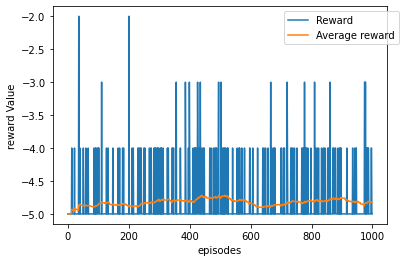

In [12]:
from alphaslime.evaluate.eval_agents import EvaluateGameSA

env_id = "SlimeVolley-v0"
env = gym.make(env_id)

# actions for slimeball
action_table = [[0, 0, 0], # NOOP
                [1, 0, 0], # LEFT (forward)
                [1, 0, 1], # UPLEFT (forward jump)
                [0, 0, 1], # UP (jump)
                [0, 1, 1], # UPRIGHT (backward jump)
                [0, 1, 0]] # RIGHT (backward)
                
# test trained model
agent_type = hyperparams_data['agent_type']
# load latest epsilon value
agent_cfg['epsilon'] = eps_list[-1]
agent_cfg['env'] = env
agent = agent_type(agent_cfg) 
eps = 1000
base_dir_path = "./"
RENDER = False
gym_evaluator = EvaluateGameSA(agent, env, base_dir_path, render=RENDER)


# evaulate agent
reward_arr, avg_rewards_array = gym_evaluator.evaluate(eps, is_progress_bar=True)

print("average reward per episode :", sum(reward_arr) / len(reward_arr))

import numpy as np
import matplotlib.pyplot as plt

rewards = np.array(reward_arr)
plt.plot(rewards, label='Reward')
plt.plot(avg_rewards_array, label='Average reward')
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.xlabel('episodes')
plt.ylabel('reward Value')
print('average reward per episode= {}'.format(np.mean(rewards)))
plt.show()